## Description:

This script used the individual AR class to foreast extreme P.

This script creates Figure S9, S10, and S11.

In [1]:
import numpy as np
import netCDF4 as nc
import datetime as dt
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cartopy
import cartopy.crs as ccrs

# for shapefile
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

%matplotlib inline

In [2]:
rootdir = '/raid1/chen423/serdp/archive/GRL2018/'

In [4]:
# merge all the preparation into one big block, for eacy restart

def get_nc_data(infile, var):
    tmpgroup = nc.Dataset(infile, 'r', format='NETCDF4')
    outdata = tmpgroup.variables[var][:]
    tmpgroup.close()
    return outdata


def split_AR_ns(ARfeature_full):
    # taking 40 as split
    latbound = 40.0
    ARlat = ARfeature_full[:,9]
    nfeatures = ARfeature_full.shape[1]
    nnorth = (ARlat>latbound).sum()
    nsouth = (ARlat<=latbound).sum()
    ARfeature_north = np.zeros((nnorth, nfeatures))
    ARfeature_south = np.zeros((nsouth, nfeatures))
    
    count_n = 0
    count_s = 0
    
    for i in np.arange(ARfeature_full.shape[0]):
        if ARfeature_full[i,9]<=latbound:
            ARfeature_south[count_s,:] = ARfeature_full[i,:]
            count_s = count_s + 1
        elif ARfeature_full[i,9]>latbound:
            ARfeature_north[count_n,:] = ARfeature_full[i,:]
            count_n = count_n + 1
    
    return ARfeature_north, ARfeature_south


def retrieve_ARclass(method, AR_class):
    file_ffeature = rootdir+'data/AR_features/part2/%s.AR_events_feature.1981-2015.nc' % (method)
    ARfeature_full = get_nc_data(file_ffeature, 'AR_event_feature')
    ARfeature_north, ARfeature_south = split_AR_ns(ARfeature_full)
    
    file_class = rootdir+'data/AR_classification/north_south_split/AR_3class.north.%s.nc' % (method)
    AR_class_index_n = get_nc_data(file_class, 'ARclass_index')
    ARfeature_norm_n = get_nc_data(file_class, 'ARfeature_norm')
    
    file_class = rootdir+'data/AR_classification/north_south_split/AR_3class.south.%s.nc' % (method)
    AR_class_index_s = get_nc_data(file_class, 'ARclass_index')
    ARfeature_norm_s = get_nc_data(file_class, 'ARfeature_norm')
    
    return AR_class_index_n[AR_class_index_n==AR_class], ARfeature_north[AR_class_index_n==AR_class], ARfeature_norm_n[AR_class_index_n==AR_class], AR_class_index_s[AR_class_index_s==AR_class], ARfeature_south[AR_class_index_s==AR_class], ARfeature_norm_s[AR_class_index_s==AR_class]


def tindex_to_monthlyindex(index):
    stime = dt.datetime(1981,1,1,0)
    time_delta = dt.timedelta(hours=3*index)
    etime = stime + time_delta
    return (etime.year-1981)*12+etime.month-1  # -1 so it is conssistent with index that starts from 0 in 1981-01


def calc_lag_corraltion(clim_index, indata, lag=0):
    outdata = np.zeros(1080)
    full_len = clim_index.shape[0]
    for i in np.arange(1080):
        outdata[i] = np.corrcoef(clim_index[0:(full_len-lag)], indata[lag:(full_len),i])[0,1]
        
    return outdata


def sub_AR_monthly_nevents(cclass, AR_class_index, ARfeature_fulldata):
    outdata_counts = np.zeros(420)
    
    for i in np.arange(AR_class_index.shape[0]):
        mindex = tindex_to_monthlyindex(ARfeature_fulldata[i,8])
        if cclass=='whole':
            outdata_counts[mindex] = outdata_counts[mindex] + 1
        else:
            if AR_class_index[i]==cclass:
                outdata_counts[mindex] = outdata_counts[mindex] + 1
                
    outdata_sig = outdata_counts.copy()
    outdata_sig[outdata_counts>=1] = 1
    
    return outdata_counts, outdata_sig


def sub_AR_monthly_accum_IntDur(cclass, AR_class_index, ARfeature_fulldata):
    # accumulation of Intensity*Duration
    outdata = np.zeros(420)
    
    for i in np.arange(AR_class_index.shape[0]):
        mindex = tindex_to_monthlyindex(ARfeature_fulldata[i,8])
        if cclass=='whole':
            outdata[mindex] = outdata[mindex] + ARfeature_fulldata[i,3]*ARfeature_fulldata[i,7]
        else:
            if AR_class_index[i]==cclass:
                outdata[mindex] = outdata[mindex] + ARfeature_fulldata[i,3]*ARfeature_fulldata[i,7]
    
    return outdata


def sub_AR_monthly_accum_IntDurAre(cclass, AR_class_index, ARfeature_fulldata):
    # accumulation of Intensity*Duration*Area_land
    outdata = np.zeros(420)
    
    for i in np.arange(AR_class_index.shape[0]):
        mindex = tindex_to_monthlyindex(ARfeature_fulldata[i,8])
        if cclass=='whole':
            outdata[mindex] = outdata[mindex] + ARfeature_fulldata[i,3]*ARfeature_fulldata[i,7]*ARfeature_fulldata[i,1]
        else:
            if AR_class_index[i]==cclass:
                outdata[mindex] = outdata[mindex] + ARfeature_fulldata[i,3]*ARfeature_fulldata[i,7]*ARfeature_fulldata[i,1]
    
    return outdata


def sub_AR_monthly_accum_IntDurWid(cclass, AR_class_index, ARfeature_fulldata):
    # accumulation of Intensity*Duration*Width_coast
    outdata = np.zeros(420)
    
    for i in np.arange(AR_class_index.shape[0]):
        mindex = tindex_to_monthlyindex(ARfeature_fulldata[i,8])
        if cclass=='whole':
            outdata[mindex] = outdata[mindex] + ARfeature_fulldata[i,5]*ARfeature_fulldata[i,7]*ARfeature_fulldata[i,4]
        else:
            if AR_class_index[i]==cclass:
                outdata[mindex] = outdata[mindex] + ARfeature_fulldata[i,5]*ARfeature_fulldata[i,7]*ARfeature_fulldata[i,4]
    
    return outdata


def get_AR_stats(method, AR_class):
    
    AR_class_index_n, ARfeature_north, ARfeature_norm_n, AR_class_index_s, ARfeature_south, ARfeature_norm_s = retrieve_ARclass(method, AR_class)
    
    # on the first index:  0 is north, 1 is south
    AR_monthly_nevents = np.zeros((2,420))
    AR_monthly_sig = np.zeros((2,420))
    AR_monthly_nevents[0,:], AR_monthly_sig[0,:] = sub_AR_monthly_nevents('whole', AR_class_index_n, ARfeature_north)
    AR_monthly_nevents[1,:], AR_monthly_sig[1,:] = sub_AR_monthly_nevents('whole', AR_class_index_s, ARfeature_south)

    AR_mon_acc_ida = np.zeros((2,420))
    AR_mon_acc_ida[0,:] = sub_AR_monthly_accum_IntDurAre('whole', AR_class_index_n, ARfeature_north)
    AR_mon_acc_ida[1,:] = sub_AR_monthly_accum_IntDurAre('whole', AR_class_index_s, ARfeature_south)
    
    
    return AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida


def sub_AR_daily_sig(cclass, AR_class_index, ARfeature_full, totaldays, lag=0):
    outdata = np.zeros(totaldays)
    for i in np.arange(AR_class_index.shape[0]):
        sindex = (dt.timedelta(hours=3*ARfeature_full[i,6])).days
        eindex = (dt.timedelta(hours=3*(ARfeature_full[i,6])+ARfeature_full[i,7])).days + lag
        if cclass=='whole':
            outdata[sindex:(eindex+1)] = np.ones(np.minimum(eindex-sindex+1, totaldays-sindex))
        else:
            if AR_class_index[i]==cclass:
                outdata[sindex:(eindex+1)] = np.ones(np.minimum(eindex-sindex+1, totaldays-sindex))
                
    return outdata


def calc_extreme_sum_monthly(dailyinput, pvalue):
    print(pvalue)
    tindex_daily = pd.date_range('1/1/1981', periods=dailyinput.shape[0])
    out_count = np.zeros((420,dailyinput.shape[1]))
    for i in np.arange(dailyinput.shape[1]):
        tmpdata = dailyinput[:,i].copy()
        threshold = np.percentile(tmpdata, pvalue*100)
        tmpdata[tmpdata<threshold]='NaN'
        tmpdata_tagged = pd.Series(tmpdata, index=tindex_daily)
        out_count[:,i] = tmpdata_tagged.resample('M').sum()
    return out_count


def calc_extreme_daily_sig(dailyinput, pvalue):
    print(pvalue)
    out_sig = np.zeros(dailyinput.shape)
    for i in np.arange(dailyinput.shape[1]):
        tmpdata = dailyinput[:,i].copy()
        threshold = np.percentile(tmpdata, pvalue*100)
        tmpdata[tmpdata<threshold]=0
        tmpdata[tmpdata>=threshold]=1
        out_sig[:,i] = tmpdata

    return out_sig


def gen_custom_positive_anomaly(indata, approach, pvalue=0.5):
    # indata: ()
    lens = indata.shape[0]
        
    outdata = np.zeros(indata.shape)
    
    for i in np.arange(indata.shape[1]):   # loop over basins
        
        if approach=='mean':
            baseline = np.mean(indata[:,i])
        elif approach=='percentile':
            baseline = np.percentile(indata[:,i], pvalue*100)
        
        outdata[:,i] = indata[:,i]-baseline
        
    outdata[outdata<0] = 0
    
    return outdata


def compute_mean_correaltions_vlags(ARstats, hydrovar, lags=np.arange(7)):
    sbasin = 734
    ebasin = 1080
    npts = lags.shape[0]
    
    corr_stats = np.zeros((npts,5))
    
    for i in np.arange(npts):
        corrdata = calc_lag_corraltion(ARstats, hydrovar, lags[i])
        corr_stats[i,0] = np.min(corrdata[sbasin:ebasin])
        corr_stats[i,1] = np.percentile(corrdata[sbasin:ebasin], 25)
        corr_stats[i,2] = np.mean(corrdata[sbasin:ebasin])
        corr_stats[i,3] = np.percentile(corrdata[sbasin:ebasin], 75)
        corr_stats[i,4] = np.max(corrdata[sbasin:ebasin])
        
    return corr_stats


def calc_binary_scores(ARdata, hydrodata, metric):

    tmpdata = hydrodata+ARdata
    yy = (tmpdata==2).sum()
    nn = (tmpdata==0).sum()
    
    # yn, ARdata==1, hydrodata==0
    tmpdata = ARdata-hydrodata
    yn = (tmpdata==1).sum()
    ny = (tmpdata==-1).sum()


    if metric=='POD':
        outvalue = yy/(yy + ny)
    elif metric=='FAR':
        outvalue = yn/(yy + yn)
    elif metric=='Bias':
        outvalue = (yy + yn)/(yy + ny)
    elif metric=='HSS':
        outvalue = 2*(yy*nn-yn*ny)/((yy+ny)*(ny+nn)+(yy+yn)*(yn+nn))
    elif metric=='TS':
        outvalue = yy/(yy + ny + yn)
    elif metric=='GSS':
        ets_tmp = (yy + yn)*(yy + ny)/(yy + ny + yn + nn)
        outvalue= (yy - ets_tmp)/(yy + ny + yn - ets_tmp)
                                  
                                  
    return outvalue


def wrap_calc_binary_score(AR_daily_sig, dailyhydro, metric):
    
    outdata = np.zeros(dailyhydro.shape[1])
    
    for i in np.arange(dailyhydro.shape[1]):
        outdata[i] = calc_binary_scores(AR_daily_sig, dailyhydro[:,i], metric)
        
    return outdata



reffile = rootdir+'data/ref_data/HU8_wUS.red005.nc'
HU8_mask = get_nc_data(reffile, 'Band1')
HU8_mask = get_nc_data(reffile, 'Band1')
lat = get_nc_data(reffile, 'lat')
lon = get_nc_data(reffile, 'lon')
hu8_list = np.genfromtxt(rootdir+'data/ref_data/hu8_list')[:,1]

lons, lats = np.meshgrid(lon, lat)

def generate_plot_data_matrix(indata):
    plot_data_matrix = np.ones(lons.shape)*9999

    for i in np.arange(1080):
        hu8id = hu8_list[i]
        plot_data_matrix[HU8_mask==hu8id] = indata[i]
    
    plot_data_matrix[plot_data_matrix==9999] = np.nan
        
    return plot_data_matrix


dailyP_file = rootdir+'data/hydro_data/WRF/NARR_hist.HUC8.P.nc'
dailyP = get_nc_data(dailyP_file, 'P')


monthly_p95P_sum = calc_extreme_sum_monthly(dailyP, 0.95)

daily_p95P_sig = calc_extreme_daily_sig(dailyP, 0.95)

0.95
0.95


## plotting

#### fig1. plot relationship between AR and P. So no lag is needed

In [8]:
def visualize_wUS_map_small(axes, indata, location, title='', method='', method2='',
                            ylim=[26,55], hu2bdy_flag=False, cmap='Blues', vmin=-0.6, vmax=0.6, ns_tag=''):
    
    axes.pcolormesh(lons, lats, indata, cmap=cmap, vmin=vmin, vmax=vmax, zorder=3)
    axes.set_xlim([-127, -100])
    axes.set_ylim(ylim)

    axes.add_feature(cartopy.feature.OCEAN, linewidth=0.5, facecolor='aliceblue', edgecolor='k', zorder=0)
    axes.add_feature(cartopy.feature.LAND, linewidth=0.5, facecolor='none', edgecolor='k', zorder=1)

    if hu2bdy_flag==True:
        shpfile = rootdir+'data/ref_data/HUC/HU2_wUS_R07-R18.shp'
        shape_feature = ShapelyFeature(Reader(shpfile).geometries(), ccrs.PlateCarree(), 
                                       facecolor='none', edgecolor='gray', linewidth=0.5)
        axes.add_feature(shape_feature, zorder=5)


    countries = cartopy.feature.NaturalEarthFeature(category='cultural', scale='10m', edgecolor='black',
                                                    linewidth=0.25, facecolor='none', name='admin_0_countries')
    axes.add_feature(countries, zorder=4)

    gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='-', alpha=1, zorder=2)
    gl.xlabels_top = False
    gl.xlabels_bottom = False
    gl.ylabels_left = False
    gl.ylabels_right = False
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-180,-59,10))
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(0,81,10))
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER
    
    if location[1]==True:
        axes.set_xticks(np.arange(-120,-109,10), crs=ccrs.PlateCarree())
        axes.set_xticklabels(('120°W','110°W'))
    if location[2]==True:
        axes.set_yticks(np.arange(30, 60, 10), crs=ccrs.PlateCarree())
        axes.set_yticklabels(('30°N','40°N','50°N'))
    axes.tick_params(labeltop=location[0], labelbottom=location[1], labelleft=location[2], labelright=location[3],
                         labelsize=8)
    
    #axes.text()  # for abcd indices
    axes.text(-122, 28, ns_tag, horizontalalignment='center', size=8, zorder=4)
    axes.text(-109, 52, method2, horizontalalignment='center', size=8, zorder=4)

guan done


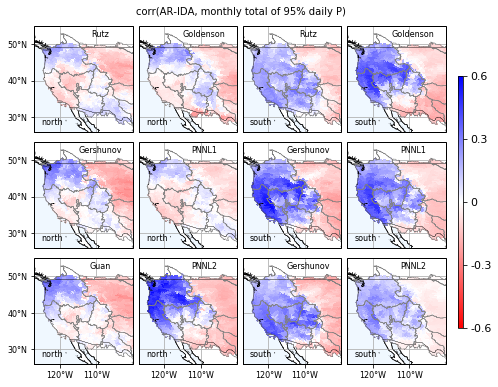

In [9]:
Pdata = monthly_p95P_sum
AR_class = 2

fig1 = plt.figure(figsize=(8,7))
ax1 = plt.subplot2grid((10,13), (1,0), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax2 = plt.subplot2grid((10,13), (1,3), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax3 = plt.subplot2grid((10,13), (4,0), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax4 = plt.subplot2grid((10,13), (4,3), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax5 = plt.subplot2grid((10,13), (7,0), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax6 = plt.subplot2grid((10,13), (7,3), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax7 = plt.subplot2grid((10,13), (1,6), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax8 = plt.subplot2grid((10,13), (1,9), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax9 = plt.subplot2grid((10,13), (4,6), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax10 = plt.subplot2grid((10,13), (4,9), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax11 = plt.subplot2grid((10,13), (7,6), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax12 = plt.subplot2grid((10,13), (7,9), rowspan=3, colspan=3, projection=ccrs.PlateCarree())

title = ''
bigtitle = 'corr(AR-IDA, monthly total of 95% daily P)'


# upper panels, north
regionindex = 0 # 0 for north, 1 for south
ns_tag = 'north'

method = 'rutz'
method2 = 'Rutz'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method, AR_class)
corrdata_raw = calc_lag_corraltion(AR_mon_acc_ida[regionindex], Pdata, 0)
plot_data = generate_plot_data_matrix(corrdata_raw)
visualize_wUS_map_small(ax1, plot_data, location=[False,False,True,False], method=method, method2=method2,
                  hu2bdy_flag=True, cmap='bwr_r', ns_tag=ns_tag)
#print(method+' done')

method = 'gershunov'
method2 = 'Gershunov'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method, AR_class)
corrdata_raw = calc_lag_corraltion(AR_mon_acc_ida[regionindex], Pdata, 0)
plot_data = generate_plot_data_matrix(corrdata_raw)
visualize_wUS_map_small(ax3, plot_data, location=[False,False,True,False], method=method, method2=method2,
                  hu2bdy_flag=True, cmap='bwr_r', ns_tag=ns_tag)
#print(method+' done')

method = 'guan'
method2 = 'Guan'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method, AR_class)
corrdata_raw = calc_lag_corraltion(AR_mon_acc_ida[regionindex], Pdata, 0)
plot_data = generate_plot_data_matrix(corrdata_raw)
visualize_wUS_map_small(ax5, plot_data, location=[False,True,True,False], method=method, method2=method2,
                  hu2bdy_flag=True, cmap='bwr_r', ns_tag=ns_tag)
print(method+' done')

method = 'goldenson'
method2 = 'Goldenson'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method, AR_class)
corrdata_raw = calc_lag_corraltion(AR_mon_acc_ida[regionindex], Pdata, 0)
plot_data = generate_plot_data_matrix(corrdata_raw)
visualize_wUS_map_small(ax2, plot_data, location=[False,False,False,False], method=method, method2=method2,
                  hu2bdy_flag=True, cmap='bwr_r', ns_tag=ns_tag)
#print(method+' done')

method = 'pnnl1'
method2 = 'PNNL1'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method, AR_class)
corrdata_raw = calc_lag_corraltion(AR_mon_acc_ida[regionindex], Pdata, 0)
plot_data = generate_plot_data_matrix(corrdata_raw)
visualize_wUS_map_small(ax4, plot_data, location=[False,False,False,False], method=method, method2=method2,
                  hu2bdy_flag=True, cmap='bwr_r', ns_tag=ns_tag)
#print(method+' done')

method = 'pnnl2'
method2 = 'PNNL2'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method, AR_class)
corrdata_raw = calc_lag_corraltion(AR_mon_acc_ida[regionindex], Pdata, 0)
plot_data = generate_plot_data_matrix(corrdata_raw)
visualize_wUS_map_small(ax6, plot_data, location=[False,True,False,False], method=method, method2=method2,
                  hu2bdy_flag=True, cmap='bwr_r', ns_tag=ns_tag)
#print(method+' done')

# upper panels, south
regionindex = 1 # 0 for north, 1 for south
ns_tag = 'south'

method = 'rutz'
method2 = 'Rutz'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method, AR_class)
corrdata_raw = calc_lag_corraltion(AR_mon_acc_ida[regionindex], Pdata, 0)
plot_data = generate_plot_data_matrix(corrdata_raw)
visualize_wUS_map_small(ax7, plot_data, location=[False,False,False,False], method=method, method2=method2,
                  hu2bdy_flag=True, cmap='bwr_r', ns_tag=ns_tag)
#print(method+' done')

method = 'gershunov'
method2 = 'Gershunov'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method, AR_class)
corrdata_raw = calc_lag_corraltion(AR_mon_acc_ida[regionindex], Pdata, 0)
plot_data = generate_plot_data_matrix(corrdata_raw)
visualize_wUS_map_small(ax9, plot_data, location=[False,False,False,False], method=method, method2=method2,
                  hu2bdy_flag=True, cmap='bwr_r', ns_tag=ns_tag)
#print(method+' done')

method = 'guan'
methos2 = 'Guan'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method, AR_class)
corrdata_raw = calc_lag_corraltion(AR_mon_acc_ida[regionindex], Pdata, 0)
plot_data = generate_plot_data_matrix(corrdata_raw)
visualize_wUS_map_small(ax11, plot_data, location=[False,True,False,False], method=method, method2=method2,
                  hu2bdy_flag=True, cmap='bwr_r', ns_tag=ns_tag)
#print(method+' done')

method = 'goldenson'
method2 = 'Goldenson'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method, AR_class)
corrdata_raw = calc_lag_corraltion(AR_mon_acc_ida[regionindex], Pdata, 0)
plot_data = generate_plot_data_matrix(corrdata_raw)
visualize_wUS_map_small(ax8, plot_data, location=[False,False,False,False], method=method, method2=method2,
                  hu2bdy_flag=True, cmap='bwr_r', ns_tag=ns_tag)
#print(method+' done')

method = 'pnnl1'
method2 = 'PNNL1'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method, AR_class)
corrdata_raw = calc_lag_corraltion(AR_mon_acc_ida[regionindex], Pdata, 0)
plot_data = generate_plot_data_matrix(corrdata_raw)
visualize_wUS_map_small(ax10, plot_data, location=[False,False,False,False], method=method, method2=method2,
                  hu2bdy_flag=True, cmap='bwr_r', ns_tag=ns_tag)
#print(method+' done')

method = 'pnnl2'
method2 = 'PNNL2'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method, AR_class)
corrdata_raw = calc_lag_corraltion(AR_mon_acc_ida[regionindex], Pdata, 0)
plot_data = generate_plot_data_matrix(corrdata_raw)
visualize_wUS_map_small(ax12, plot_data, location=[False,True,False,False], method=method, method2=method2,
                  hu2bdy_flag=True, cmap='bwr_r', ns_tag=ns_tag)
#print(method+' done')

cbar_axes = fig1.add_axes([0.86, 0.2, 0.01, 0.5])
cb = matplotlib.colorbar.ColorbarBase(cbar_axes, cmap='bwr_r', ticks=[np.arange(0,1.01,0.25)], orientation='vertical')
cb.set_ticklabels(['-0.6', '-0.3', '0', '0.3', '0.6'])
cbar_axes.tick_params(labelsize=11)

ax2.text(-99, 58, bigtitle, horizontalalignment='center', size=10)



plt.show()
plt.close()
del(fig1)

#### GSS/HSS map

see which regions are more predicable based on AR

In [10]:
def crt_MS_norm_colormap(cmapname):
    full_info = {'precip3_9segs':['#ffffff', '#b5c9ff', '#7f96ff', '#0063ff', '#00c633', '#96ff00', '#ffff00', '#ffa000', '#ff1900']              
    }
    
    if cmapname=='demo':
        print(full_info.get('demo'))
    else:
        return matplotlib.colors.ListedColormap(full_info.get(cmapname))

In [11]:
def visualize_wUS_map_full_cus_cbar_small(axes, indata, location, cmap, norm, title='', method='', method2='',
                                          ylim=[26,55], hu2bdy_flag=False, ns_tag=''):
    
    axes.pcolormesh(lons, lats, indata, cmap=cmap, norm=norm, zorder=3)
    axes.set_xlim([-127, -100])
    axes.set_ylim(ylim)

    axes.add_feature(cartopy.feature.OCEAN, linewidth=0.5, facecolor='aliceblue', edgecolor='k', zorder=0)
    axes.add_feature(cartopy.feature.LAND, linewidth=0.5, facecolor='none', edgecolor='k', zorder=1)

    if hu2bdy_flag==True:
        shpfile = rootdir+'data/ref_data/HUC/HU2_wUS_R07-R18.shp'
        shape_feature = ShapelyFeature(Reader(shpfile).geometries(), ccrs.PlateCarree(), 
                                       facecolor='none', edgecolor='gray', linewidth=0.5)
        axes.add_feature(shape_feature, zorder=5)


    countries = cartopy.feature.NaturalEarthFeature(category='cultural', scale='10m', edgecolor='black', linewidth=0.25,\
                                                    facecolor='none', name='admin_1_states_provinces')
    axes.add_feature(countries, zorder=4)

    gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='-', alpha=1, zorder=2)
    gl.xlabels_top = False
    gl.xlabels_bottom = False
    gl.ylabels_left = False
    gl.ylabels_right = False
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-180,-59,10))
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(0,81,10))
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER
    
    if location[1]==True:
        axes.set_xticks(np.arange(-120,-109,10), crs=ccrs.PlateCarree())
        axes.set_xticklabels(('120°W','110°W'))
    if location[2]==True:
        axes.set_yticks(np.arange(30, 60, 10), crs=ccrs.PlateCarree())
        axes.set_yticklabels(('30°N','40°N','50°N'))
    axes.tick_params(labeltop=location[0], labelbottom=location[1], labelleft=location[2], labelright=location[3],
                         labelsize=8)
    
    #axes.text()  # for abcd indices
    axes.text(-122, 28, ns_tag, horizontalalignment='center', size=8, zorder=4)
    axes.text(-109, 52, method2, horizontalalignment='center', size=8, zorder=4)

rutz done
gershunov done
guan done
goldenson done
pnnl1 done
pnnl2 done


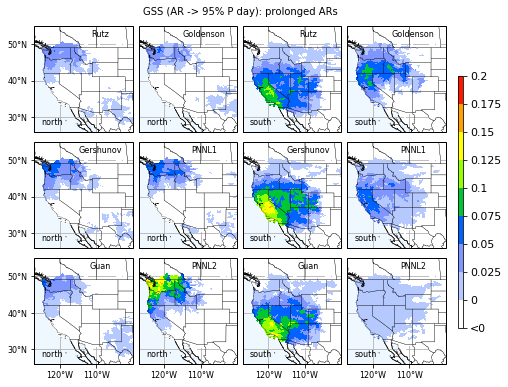

In [12]:
totaldays = dailyP.shape[0]
score = 'GSS'
AR_class = 2

fig2 = plt.figure(figsize=(8,7))
ax1 = plt.subplot2grid((10,13), (1,0), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax2 = plt.subplot2grid((10,13), (1,3), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax3 = plt.subplot2grid((10,13), (4,0), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax4 = plt.subplot2grid((10,13), (4,3), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax5 = plt.subplot2grid((10,13), (7,0), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax6 = plt.subplot2grid((10,13), (7,3), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax7 = plt.subplot2grid((10,13), (1,6), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax8 = plt.subplot2grid((10,13), (1,9), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax9 = plt.subplot2grid((10,13), (4,6), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax10 = plt.subplot2grid((10,13), (4,9), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax11 = plt.subplot2grid((10,13), (7,6), rowspan=3, colspan=3, projection=ccrs.PlateCarree())
ax12 = plt.subplot2grid((10,13), (7,9), rowspan=3, colspan=3, projection=ccrs.PlateCarree())

title = ''
bigtitle = 'GSS (AR -> 95% P day): prolonged ARs'


cmap = crt_MS_norm_colormap('precip3_9segs')
norm = matplotlib.colors.Normalize(vmin=-0.025,vmax=0.2)

dailyP_sig = daily_p95P_sig

method = 'rutz'
method2 = 'Rutz'
AR_class_index_n, ARfeature_north, ARfeature_norm_n, AR_class_index_s, ARfeature_south, ARfeature_norm_s = retrieve_ARclass(method, AR_class)
# north
AR_daily_sig = sub_AR_daily_sig('whole', AR_class_index_n, ARfeature_north, totaldays, lag=0)
scoredata = wrap_calc_binary_score(AR_daily_sig, dailyP_sig, score)
scoredata[scoredata<0] = -0.01
plot_data = generate_plot_data_matrix(scoredata)
visualize_wUS_map_full_cus_cbar_small(ax1, plot_data, location=[False,False,True,False], cmap=cmap, norm=norm,
                  title=title, method=method, method2=method2, hu2bdy_flag=False, ns_tag='north')
#south
AR_daily_sig = sub_AR_daily_sig('whole', AR_class_index_s, ARfeature_south, totaldays, lag=0)
scoredata = wrap_calc_binary_score(AR_daily_sig, dailyP_sig, score)
scoredata[scoredata<0] = -0.01
plot_data = generate_plot_data_matrix(scoredata)
visualize_wUS_map_full_cus_cbar_small(ax7, plot_data, location=[False,False,False,False], cmap=cmap, norm=norm,
                  title=title, method=method, method2=method2, hu2bdy_flag=False, ns_tag='south')
print(method+' done')

method = 'gershunov'
method2 = 'Gershunov'
AR_class_index_n, ARfeature_north, ARfeature_norm_n, AR_class_index_s, ARfeature_south, ARfeature_norm_s = retrieve_ARclass(method, AR_class)
#north
AR_daily_sig = sub_AR_daily_sig('whole', AR_class_index_n, ARfeature_north, totaldays, lag=0)
scoredata = wrap_calc_binary_score(AR_daily_sig, dailyP_sig, score)
scoredata[scoredata<0] = -0.01
plot_data = generate_plot_data_matrix(scoredata)
visualize_wUS_map_full_cus_cbar_small(ax3, plot_data, location=[False,False,True,False], cmap=cmap, norm=norm,
                  title=title, method=method, method2=method2, hu2bdy_flag=False, ns_tag='north')
#south
AR_daily_sig = sub_AR_daily_sig('whole', AR_class_index_s, ARfeature_south, totaldays, lag=0)
scoredata = wrap_calc_binary_score(AR_daily_sig, dailyP_sig, score)
scoredata[scoredata<0] = -0.01
plot_data = generate_plot_data_matrix(scoredata)
visualize_wUS_map_full_cus_cbar_small(ax9, plot_data, location=[False,False,False,False], cmap=cmap, norm=norm,
                  title=title, method=method, method2=method2, hu2bdy_flag=False, ns_tag='south')
print(method+' done')

method = 'guan'
method2 = 'Guan'
AR_class_index_n, ARfeature_north, ARfeature_norm_n, AR_class_index_s, ARfeature_south, ARfeature_norm_s = retrieve_ARclass(method, AR_class)
#north
AR_daily_sig = sub_AR_daily_sig('whole', AR_class_index_n, ARfeature_north, totaldays, lag=0)
scoredata = wrap_calc_binary_score(AR_daily_sig, dailyP_sig, score)
scoredata[scoredata<0] = -0.01
plot_data = generate_plot_data_matrix(scoredata)
visualize_wUS_map_full_cus_cbar_small(ax5, plot_data, location=[False,True,True,False], cmap=cmap, norm=norm,
                  title=title, method=method, method2=method2, hu2bdy_flag=False, ns_tag='north')
#south
AR_daily_sig = sub_AR_daily_sig('whole', AR_class_index_s, ARfeature_south, totaldays, lag=0)
scoredata = wrap_calc_binary_score(AR_daily_sig, dailyP_sig, score)
scoredata[scoredata<0] = -0.01
plot_data = generate_plot_data_matrix(scoredata)
visualize_wUS_map_full_cus_cbar_small(ax11, plot_data, location=[False,True,False,False], cmap=cmap, norm=norm,
                  title=title, method=method, method2=method2, hu2bdy_flag=False, ns_tag='south')
print(method+' done')

method = 'goldenson'
method2 = 'Goldenson'
AR_class_index_n, ARfeature_north, ARfeature_norm_n, AR_class_index_s, ARfeature_south, ARfeature_norm_s = retrieve_ARclass(method, AR_class)
#north
AR_daily_sig = sub_AR_daily_sig('whole', AR_class_index_n, ARfeature_north, totaldays, lag=0)
scoredata = wrap_calc_binary_score(AR_daily_sig, dailyP_sig, score)
scoredata[scoredata<0] = -0.01
plot_data = generate_plot_data_matrix(scoredata)
visualize_wUS_map_full_cus_cbar_small(ax2, plot_data, location=[False,False,False,False], cmap=cmap, norm=norm,
                  title=title, method=method, method2=method2, hu2bdy_flag=False, ns_tag='north')
#south
AR_daily_sig = sub_AR_daily_sig('whole', AR_class_index_s, ARfeature_south, totaldays, lag=0)
scoredata = wrap_calc_binary_score(AR_daily_sig, dailyP_sig, score)
scoredata[scoredata<0] = -0.01
plot_data = generate_plot_data_matrix(scoredata)
visualize_wUS_map_full_cus_cbar_small(ax8, plot_data, location=[False,False,False,False], cmap=cmap, norm=norm,
                  title=title, method=method, method2=method2, hu2bdy_flag=False, ns_tag='south')
print(method+' done')

method = 'pnnl1'
method2 = 'PNNL1'
AR_class_index_n, ARfeature_north, ARfeature_norm_n, AR_class_index_s, ARfeature_south, ARfeature_norm_s = retrieve_ARclass(method, AR_class)
#north
AR_daily_sig = sub_AR_daily_sig('whole', AR_class_index_n, ARfeature_north, totaldays, lag=0)
scoredata = wrap_calc_binary_score(AR_daily_sig, dailyP_sig, score)
scoredata[scoredata<0] = -0.01
plot_data = generate_plot_data_matrix(scoredata)
visualize_wUS_map_full_cus_cbar_small(ax4, plot_data, location=[False,False,False,False], cmap=cmap, norm=norm,
                  title=title, method=method, method2=method2, hu2bdy_flag=False, ns_tag='north')
#south
AR_daily_sig = sub_AR_daily_sig('whole', AR_class_index_s, ARfeature_south, totaldays, lag=0)
scoredata = wrap_calc_binary_score(AR_daily_sig, dailyP_sig, score)
scoredata[scoredata<0] = -0.01
plot_data = generate_plot_data_matrix(scoredata)
visualize_wUS_map_full_cus_cbar_small(ax10, plot_data, location=[False,False,False,False], cmap=cmap, norm=norm,
                  title=title, method=method, method2=method2, hu2bdy_flag=False, ns_tag='south')
print(method+' done')

method = 'pnnl2'
method2 = 'PNNL2'
AR_class_index_n, ARfeature_north, ARfeature_norm_n, AR_class_index_s, ARfeature_south, ARfeature_norm_s = retrieve_ARclass(method, AR_class)
#north
AR_daily_sig = sub_AR_daily_sig('whole', AR_class_index_n, ARfeature_north, totaldays, lag=0)
scoredata = wrap_calc_binary_score(AR_daily_sig, dailyP_sig, score)
scoredata[scoredata<0] = -0.01
plot_data = generate_plot_data_matrix(scoredata)
visualize_wUS_map_full_cus_cbar_small(ax6, plot_data, location=[False,True,False,False], cmap=cmap, norm=norm,
                  title=title, method=method, method2=method2, hu2bdy_flag=False, ns_tag='north')
#south
AR_daily_sig = sub_AR_daily_sig('whole', AR_class_index_s, ARfeature_south, totaldays, lag=0)
scoredata = wrap_calc_binary_score(AR_daily_sig, dailyP_sig, score)
scoredata[scoredata<0] = -0.01
plot_data = generate_plot_data_matrix(scoredata)
visualize_wUS_map_full_cus_cbar_small(ax12, plot_data, location=[False,True,False,False], cmap=cmap, norm=norm,
                  title=title, method=method, method2=method2, hu2bdy_flag=False, ns_tag='south')
print(method+' done')


cbar_axes = fig2.add_axes([0.86, 0.2, 0.01, 0.5])
cb = matplotlib.colorbar.ColorbarBase(cbar_axes, cmap=cmap, ticks=[np.arange(0,1.01,1/9)], orientation='vertical')
cb.set_ticklabels(['<0', '0', '0.025', '0.05', '0.075', '0.1', '0.125', '0.15', '0.175', '0.2'])
cbar_axes.tick_params(labelsize=11)

ax2.text(-99, 58, bigtitle, horizontalalignment='center', size=10)

#fig2.savefig(rootdir+'plots/figS11.png', dpi=600)
plt.show()
plt.close()
del(fig2)